# Tracking objects by color

How it works:
The system tracks object based on their colors.
Steps:
- we treat each frame from video as separete image;
- convert an image into HSV;
- based on color bounds find a mask;
- delete small artifacts;

<img src="res/demo/mask_00.png" width="400" height="200">
<img src="res/demo/mask_01.png" width="400" height="200">

- for each mask, finds contours and draw circle around an object;

<img src="res/demo/Extracted.png" width="400" height="200">


- while processing we save centers of objects into deques;
- later we draw the contrails of objects;
- contrails are thicker near object and thiner away from object.

<img src="res/demo/kang_0500.jpg" width="400" height="200">

## Utilities

In [12]:
from collections import deque
from imutils.video import VideoStream
import numpy as np
import cv2
import imutils
import time
from matplotlib import pyplot as plt


In [13]:
# Show result in seperate window
def show_result(img):
    cv2.imshow('image',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
# Saving video utilities
import glob
DEBUG_COUNT = 20

def process_video(path, func, dst_folder, debug = False):
    cap = cv2.VideoCapture(path)
    i = 0
    while(cap.isOpened()):
        # vid_capture.read() methods returns a tuple, first element is a bool 
        # and the second is frame
        ret, frame = cap.read()
        if ret == True:
            f = frame.copy()
            res = func(f)
            
            # Save frame into image file
            s = ""
            if(i < 10):
                s = "000"
            elif(i < 100):
                s = "00"
            elif(i < 1000):
                s = "0"
            cv2.imwrite('res\\' + dst_folder + '\\kang_'+ s +str(i)+'.jpg',res)
            i = i + 1

            # displaying the video
            #cv2.imshow("Processed Video",res)
            if debug and i > DEBUG_COUNT:
                break
                
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            break

    cap.release()
    cv2.destroyAllWindows()
    
def save_img2video(dst_folder, name = 'output.mp4'):
    # Save images into a video file
    img_array = []
    for filename in glob.glob('res\\' + dst_folder + '\\kang*.jpg'):
        #print(filename)
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)

    out = cv2.VideoWriter(name, cv2.VideoWriter_fourcc(*'DIVX'), 30, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()
    
def save_clips(path, dst_folder, idxs):
    cap = cv2.VideoCapture(path)
    i = 0
    it = iter(idxs)
    val = next(it)
    while(cap.isOpened()):
        # vid_capture.read() methods returns a tuple, first element is a bool 
        # and the second is frame
        ret, frame = cap.read()
        i = i + 1
        if ret == True:
            if i == val:
                cv2.imwrite(dst_folder + '\\clip_' +str(i)+'.png',frame)
                
                try:
                    val = next(it)
                except:
                    break
        else:
            break

    cap.release()
    cv2.destroyAllWindows()

In [19]:
def param_selection(image, args_dict, func):
    def nothing(x):
        pass
    # Create a window
    cv2.namedWindow('image')
    args = args_dict.keys()
    # Initialize values
    vals = np.zeros(len(args), dtype='int')
    pVals = np.zeros(len(args), dtype='int')
    for arg in args:
        val = args_dict[arg]
        cv2.createTrackbar(arg, 'image', val[0], val[1], nothing)
    for arg in args:
        val = args_dict[arg]
        cv2.setTrackbarPos(arg, 'image', val[2])

    # Get current positions of all trackbars
        for i, arg in enumerate(args):
            vals[i] = cv2.getTrackbarPos(arg, 'image')
    result = func(image, vals) # Apply changes

    while(1):
        # Get current positions of all trackbars
        for i, arg in enumerate(args):
            vals[i] = cv2.getTrackbarPos(arg, 'image')

        if np.any(np.not_equal(vals, pVals)):
            result = func(image, vals) # Apply changes
            s = ""
            for i, arg in enumerate(args):
                s = s + arg + " = " + str(vals[i]) + " "
            print(s)
            for i in range(len(args)):
                pVals[i] = vals[i]

        # Display result image
        cv2.imshow('image', result)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cv2.destroyWindow("image")
    cv2.destroyAllWindows()
    
# Collect images during changes to show them with or without histogram
def plot_steps(imgs, names, cols = 3, with_hist = False):
    n = len(imgs)
    rows = int(np.ceil(n / cols))
    k = 2 if with_hist else 1
    fig, axs = plt.subplots(k * rows, cols, figsize=(24, 6 * k * rows))
    for ax in axs.ravel(): # remove axis from all canvas
        ax.axis("off")
    for i, img in enumerate(imgs):
        if with_hist:
            ax = axs[k * (i // cols) + 1, i % cols]
            #print(image.ndim)
            #img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ax.hist(img.ravel())
        ax = axs[k * (i // cols), i % cols]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(names[i])
        
def plot_result(original, result):
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    ax = axs[0]
    ax.imshow(original)
    ax.set_title('Original')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = axs[1]
    ax.imshow(result, cmap='gray', label='Result')
    ax.set_title('Result')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
def plot_histogram(img):
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    plt.plot(hist)
    plt.xlim([0,256])
    
# Delete small white pixels
def delete_small_artifacts(img):
    kernel = np.ones((4,4),np.uint8)
    img = cv2.erode(img,kernel,iterations = 2)
    img = cv2.dilate(img,kernel,iterations = 2)
    return img

# Show result in seperate window
def show_result(img):
    cv2.imshow('image',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
# Choose only contours that big enough
def filter_contours(contours, upper_area_thresh = 100):
    # Find contours with area more than area_thresh
    contours = np.array(contours, dtype='object')
    f = np.vectorize(cv2.contourArea)
    areas = f(contours)
    areas = np.where(areas > upper_area_thresh)
    contours = contours[areas]
    return contours
    
def fill_contours(img, upper_area_thresh = 100, color = (0, 0, 0), external = False, clear_background = False, show_border = False):
    mode = cv2.RETR_EXTERNAL if external else cv2.RETR_TREE
    contours, hierarchy  = cv2.findContours(img, mode, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[1:]
    contours = filter_contours(contours, upper_area_thresh)
    if clear_background:
        img = np.zeros([img.shape[0], img.shape[1]],dtype=np.uint8)
        img =255 - img
    if show_border:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(img, contours, -1, (0, 255, 255), 5)
    for cnt in contours:
        cv2.fillPoly(img, pts=[cnt], color=color)
    print('Count of objects', len(contours))
    return img
    
def draw_border(img, thickness = 5, mode = 0):
    # mode = 0 - top line, 1 - right, 2 - bottom, 3 - left
    color = (255, 255, 255)
    if mode == 0:
        cv2.line(img,(0,0),(img.shape[1],0),color,thickness=thickness)
    if mode == 1:
        cv2.line(img,(img.shape[1],0),(img.shape[1],img.shape[0]),color,thickness=thickness)
    if mode == 2:
        cv2.line(img,(0,img.shape[0]),(img.shape[1],img.shape[0]),color,thickness=thickness)
    if mode == 3:
        cv2.line(img,(0,0),(0,img.shape[0]),color,thickness)
    return img

## Tracking

In [24]:
args = {"video": "tracking_by_color.mp4", "buffer": 64}
VIDEO_PATH = args["video"]

### Parameter selection

In [25]:
save_clips(VIDEO_PATH, 'tmp', [5, 267, 400, 500, 700])  

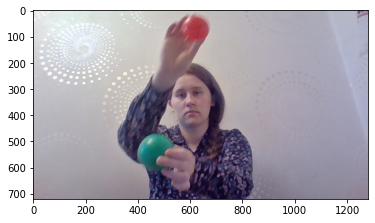

In [26]:
IMG_PATH = "tmp\clip_500.png"
image = cv2.imread(IMG_PATH)
img = image.copy()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [49]:
d = {'hMin': (0, 179, 0), 'sMin': (0, 255, 0), 'vMin': (0, 255, 0), 'hMax': (0, 179, 179), 'sMax': (0, 255, 255), 'vMax': (0, 255, 255)}
def inRange(image, vals):
    image = imutils.resize(image, width=1200)
    lower = np.array([vals[0], vals[1], vals[2]])
    upper = np.array([vals[3], vals[4], vals[5]])
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower, upper)
    res = cv2.bitwise_and(image, image, mask=mask)
    return res
param_selection(img, d, inRange)

hMin = 0 sMin = 0 vMin = 0 hMax = 179 sMax = 255 vMax = 255 


### Tracking objects

In [27]:
greenLower = (32, 27, 46)
greenUpper = (99, 255, 239)
redLower = (113, 130, 106)
redUpper = (179, 255, 255)
bounds = [(greenLower, greenUpper), (redLower, redUpper)]

In [28]:
def mask_by_color(hsv, low, up):
    mask = cv2.inRange(hsv, low, up)
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)
    return mask
def extract_by_color(img):
    # resize the frame, blur it, and convert it to the HSV
    # color space
    blurred = cv2.GaussianBlur(img, (11, 11), 0)
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
    # construct a mask for the color "green", then perform
    # a series of dilations and erosions to remove any small
    # blobs left in the mask
    mask1 = mask_by_color(hsv, greenLower, greenUpper)
    mask2 = mask_by_color(hsv, redLower, redUpper)
    mask = cv2.bitwise_or(mask1, mask2)
    return mask

def extract_by_colors(img, bounds = bounds):
    # resize the frame, blur it, and convert it to the HSV
    # color space
    blurred = cv2.GaussianBlur(img, (11, 11), 0)
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
    # construct a mask for the color "green", then perform
    # a series of dilations and erosions to remove any small
    # blobs left in the mask
    masks = []
    for low, up in bounds:
        mask = mask_by_color(hsv, low, up)
        masks.append(mask)
    return masks

idx = 2
ptss = {0: dict(), 1: dict()}
def find_contour(image, mask, i):
    global idx
    # find contours in the mask and initialize the current
    # (x, y) center of the ball
    cnts, hierarchy = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #cnts = imutils.grab_contours(cnts)
    center = None
    # only proceed if at least one contour was found
    if len(cnts) > 0:
        key_used = set()
        #c = max(cnts, key=cv2.contourArea)
        pts = ptss[i]
        for c in cnts:
            area = cv2.contourArea(c)
            if area < 400:
                continue
            ((x, y), radius) = cv2.minEnclosingCircle(c)
            M = cv2.moments(c)
            center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
            # only proceed if the radius meets a minimum size
            if radius > 25:
            # draw the circle and centroid on the frame,
            # then update the list of tracked points
                cv2.circle(image, (int(x), int(y)), int(radius), (0, 255, 255), 2)
                cv2.circle(image, center, 5, (0, 0, 255), -1)
            if not pts:
                pts[1] = deque(maxlen=args["buffer"])
                pts[1].appendleft(center)
                key_used.add(1)
            else:
                for key in pts:
                    pt = pts[key]
                    prev = pt.popleft()
                    pt.appendleft(prev)
                    if prev == None:
                        continue
                    dist = (prev[0] - center[0]) ** 2 + (prev[1] - center[1]) ** 2
                    if dist < 10000:
                        pt.appendleft(center)
                        key_used.add(key)
                if len(key_used) == 0:
                    # New object
                    pts[idx] = deque(maxlen=args["buffer"])
                    pts[idx].appendleft(center)
                    key_used.add(idx)
                    idx = idx + 1
        for key in pts:
            if not(key in key_used):
                pts[key].appendleft(None)
    return image
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
def draw_contrail(image, pts_dict):
    for i in pts_dict:
        pts_s = pts_dict[i]
        color = colors[i % len(colors)]
        for key in pts_s:
            pts = pts_s[key]
            for i in range(1, len(pts)):
            # if either of the tracked points are None, ignore them
                if pts[i - 1] is None or pts[i] is None:
                    continue
                # otherwise, compute the thickness of the line and
                # draw the connecting lines
                thickness = int(np.sqrt(args["buffer"] / float(i + 1)) * 2.5)
                cv2.line(image, pts[i - 1], pts[i], color, thickness)
    return image
    

def process(image, debug = True):
    masks = extract_by_colors(image)
    for i, mask in enumerate(masks):
        image = find_contour(image, mask, i)
    image = draw_contrail(image, ptss) 
    if debug:
        for i, mask in enumerate(masks):
            cv2.imwrite("debug/mask_0" + str(i) + ".png", mask)
    
    return image  

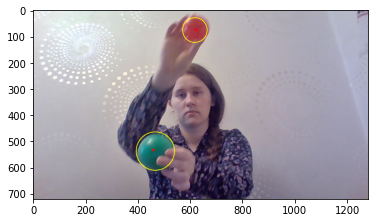

In [29]:
img = image.copy()
res = process(img, True)
cv2.imwrite("Extracted.png", res)
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
plt.imshow(res)

In [92]:
ptss

{0: {1: deque([(460, 533)])}, 1: {1: deque([(623, 76)])}}

In [93]:
def clear_folder(folder):
    import os, shutil
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [98]:
clear_folder('res/tmp_extract')
idx = 2
ptss = {0: dict(), 1: dict()}

In [100]:
process_video(VIDEO_PATH, process, 'tmp_extract', debug = False)

In [103]:
save_img2video('tmp_extract', 'tracked.mp4')

# Centroid tracking algorithm

Purpose: Having centres of objects from sequential frames we need to reconstruct their trails. 

Steps: 
- Each detected objects get their IDs and bounding boxes; 
- For each centre from 1st frame we look for the closest centre from the 2d frame 
- If some centres are left from 2d frame, it means that new objects appear; 
- If some centres are left from 1st frame, it means that some objects disappear; 

Procs: 
- Quite simple to implement; 

Cons: 
- Might be time-consuming since we need to detect objects for each frame; 
- Might be ID switching if objects cross each other; 
- Might be IDs switching if one object disappears, another one appear simultaneously (check)

Technical description:
We have a class CentroidTracker with following fields:
- nextObjectID is a ID for next object;
- objects is a dictionary of currect objects with their centers (x, y);
- disappeared is a dictionary that shows how many frames object is absent;
- maxDisappeared is a maximum lifetime after disappearing.
We have 3 methods:
- register - add new object;
- dergister - delete absent object;
- update - update tracking information.
How update method works:
- if there are no rectangles, we increase disappeared values for each objects and check whether we need to deregister them;
- if there are rectangles we try to match its centers with previous objects;
- we find the smallest distances between pairs of previous centers and new ones;
- if some rows or columns are unused it means that there are new objects or some objects disappear and register them or increase disappear field if needed;

## Questions
1) How to draw contrails by having list of object centers of each frame? 
2) What is the main idea of centeroid tracking algorithm? 

In [ ]:
# import the necessary packages
from scipy.spatial import distance as dist
from collections import OrderedDict
import numpy as np
class CentroidTracker():
	def __init__(self, maxDisappeared=50):
		# initialize the next unique object ID along with two ordered
		# dictionaries used to keep track of mapping a given object
		# ID to its centroid and number of consecutive frames it has
		# been marked as "disappeared", respectively
		self.nextObjectID = 0
		self.objects = OrderedDict()
		self.disappeared = OrderedDict()
		# store the number of maximum consecutive frames a given
		# object is allowed to be marked as "disappeared" until we
		# need to deregister the object from tracking
		self.maxDisappeared = maxDisappeared
	def register(self, centroid):
		# when registering an object we use the next available object
		# ID to store the centroid
		self.objects[self.nextObjectID] = centroid
		self.disappeared[self.nextObjectID] = 0
		self.nextObjectID += 1
	def deregister(self, objectID):
		# to deregister an object ID we delete the object ID from
		# both of our respective dictionaries
		del self.objects[objectID]
		del self.disappeared[objectID]
	def update(self, rects):
		# check to see if the list of input bounding box rectangles
		# is empty
		if len(rects) == 0:
			# loop over any existing tracked objects and mark them
			# as disappeared
			for objectID in list(self.disappeared.keys()):
				self.disappeared[objectID] += 1
				# if we have reached a maximum number of consecutive
				# frames where a given object has been marked as
				# missing, deregister it
				if self.disappeared[objectID] > self.maxDisappeared:
					self.deregister(objectID)
			# return early as there are no centroids or tracking info
			# to update
			return self.objects
		# initialize an array of input centroids for the current frame
		inputCentroids = np.zeros((len(rects), 2), dtype="int")
		# loop over the bounding box rectangles
		for (i, (startX, startY, endX, endY)) in enumerate(rects):
			# use the bounding box coordinates to derive the centroid
			cX = int((startX + endX) / 2.0)
			cY = int((startY + endY) / 2.0)
			inputCentroids[i] = (cX, cY)
		# if we are currently not tracking any objects take the input
		# centroids and register each of them
		if len(self.objects) == 0:
			for i in range(0, len(inputCentroids)):
				self.register(inputCentroids[i])
		# otherwise, are are currently tracking objects so we need to
		# try to match the input centroids to existing object
		# centroids
		else:
			# grab the set of object IDs and corresponding centroids
			objectIDs = list(self.objects.keys())
			objectCentroids = list(self.objects.values())
			# compute the distance between each pair of object
			# centroids and input centroids, respectively -- our
			# goal will be to match an input centroid to an existing
			# object centroid
			D = dist.cdist(np.array(objectCentroids), inputCentroids)
			# in order to perform this matching we must (1) find the
			# smallest value in each row and then (2) sort the row
			# indexes based on their minimum values so that the row
			# with the smallest value is at the *front* of the index
			# list
			rows = D.min(axis=1).argsort()
			# next, we perform a similar process on the columns by
			# finding the smallest value in each column and then
			# sorting using the previously computed row index list
			cols = D.argmin(axis=1)[rows]
			# in order to determine if we need to update, register,
			# or deregister an object we need to keep track of which
			# of the rows and column indexes we have already examined
			usedRows = set()
			usedCols = set()
			# loop over the combination of the (row, column) index
			# tuples
			for (row, col) in zip(rows, cols):
				# if we have already examined either the row or
				# column value before, ignore it
				# val
				if row in usedRows or col in usedCols:
					continue
				# otherwise, grab the object ID for the current row,
				# set its new centroid, and reset the disappeared
				# counter
				objectID = objectIDs[row]
				self.objects[objectID] = inputCentroids[col]
				self.disappeared[objectID] = 0
				# indicate that we have examined each of the row and
				# column indexes, respectively
				usedRows.add(row)
				usedCols.add(col)
			# compute both the row and column index we have NOT yet
			# examined
			unusedRows = set(range(0, D.shape[0])).difference(usedRows)
			unusedCols = set(range(0, D.shape[1])).difference(usedCols)
			# in the event that the number of object centroids is
			# equal or greater than the number of input centroids
			# we need to check and see if some of these objects have
			# potentially disappeared
			if D.shape[0] >= D.shape[1]:
				# loop over the unused row indexes
				for row in unusedRows:
					# grab the object ID for the corresponding row
					# index and increment the disappeared counter
					objectID = objectIDs[row]
					self.disappeared[objectID] += 1
					# check to see if the number of consecutive
					# frames the object has been marked "disappeared"
					# for warrants deregistering the object
					if self.disappeared[objectID] > self.maxDisappeared:
						self.deregister(objectID)
			# otherwise, if the number of input centroids is greater
			# than the number of existing object centroids we need to
			# register each new input centroid as a trackable object
			else:
				for col in unusedCols:
					self.register(inputCentroids[col])
		# return the set of trackable objects
		return self.objects

In [49]:
# Centroid Algorithm
def find_bounding_boxes(image, mask):
    rects = []
    cnts, hierarchy = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(cnts) > 0:
        for c in cnts:
            area = cv2.contourArea(c)
            if area < 400:
                continue
            x, y, w, h = cv2.boundingRect(c)
            rects.append((x, y, x + w, y + h))
            cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),3)
    return rects

# initialize our centroid tracker and frame dimensions
ct = CentroidTracker()
def process_centroid_algorithm(image, debug = True):
    masks = extract_by_colors(image)
    rects = []
    for i, mask in enumerate(masks):
        r = find_bounding_boxes(image, mask)
        rects.extend(r)
    if debug:
        for i, mask in enumerate(masks):
            cv2.imwrite("debug/mask_0" + str(i) + ".png", image)
    objects = ct.update(rects)
    # loop over the tracked objects
    for (objectID, centroid) in objects.items():
        # draw both the ID of the object and the centroid of the object on the output frame
        text = "ID {}".format(objectID)
        cv2.putText(image, text, (centroid[0] - 10, centroid[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 5)
        cv2.circle(image, (centroid[0], centroid[1]), 7, (0, 255, 0), -1)
        
    return image

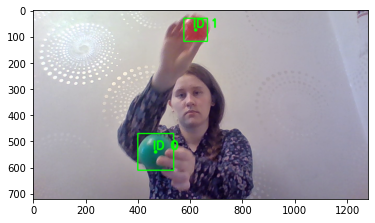

In [47]:
img = image.copy()
res = process_centroid_algorithm(img, True)
cv2.imwrite("Extracted.png", res)
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
plt.imshow(res)

In [50]:
process_video(VIDEO_PATH, process_centroid_algorithm, 'tmp_extract', debug = False)

# Explanations
## Distance relation explanation

In [2]:
# Distance relation
from scipy.spatial import distance as dist
import numpy as np
np.random.seed(42)
objectCentroids = np.random.uniform(size=(2, 2)) # 2 points
centroids = np.random.uniform(size=(3, 2)) # 3 points
D = dist.cdist(objectCentroids, centroids)
print("D:")
print(D)
print("D.min(axis=1):")
print(D.min(axis=1))
print("rows:")
rows = D.min(axis=1).argsort()
print(rows)
# For objectCentroids[0] the best match is centroids[1], for objectCentroids[1] the best match is centroids[2]

D:
[[0.82421549 0.32755369 0.33198071]
 [0.72642889 0.72506609 0.17058938]]
D.min(axis=1):
[0.32755369 0.17058938]
rows:
[1 0]


In [3]:
print("D.argmin(axis=1):")
print(D.argmin(axis=1))
cols = D.argmin(axis=1)[rows]
print("cols:")
print(cols)

D.argmin(axis=1):
[1 2]
cols:
[2 1]


In [4]:
print("Pairs:")
print(list(zip(rows, cols)))

Pairs:
[(1, 2), (0, 1)]


# Snippets

In [8]:
## Snippets
# Load the model - use raw link (click button on the page)
import requests
URL = "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt"
response = requests.get(URL)
open(PROTOTXT, "wb").write(response.content)

28104

# References
- Ball Tracking with OpenCV by Adrian Rosebrock on September 14, 2015, https://pyimagesearch.com/2015/09/14/ball-tracking-with-opencv/

In [58]:
s = float(input("s="))
N = int(input("N="))
x = float(input("x="))
sk = s
s1 = 0
for i in range(1, N + 1):
    s1 = s1 + np.log(np.sqrt(sk))
    sk = sk * s
    s2 = 0
    xn = 1
for n in range(1, N - 1):
    xn = xn * x
    xnp = xn
    for p in range(n + 1):
        s2 = s2 + xnp
        xnp = xnp * x
y = s1 + s2 / 2
print("result", y)

s= 5
N= 10
x= 0.5


result 45.0889722184026
